librosa - модуль для препроцессинга аудио

sklearn - модуль для обучения

In [1]:
#!python3 -m pip install --upgrade pip
#!python3 -m pip install librosa sklearn

In [1]:
from scipy.io.wavfile import read
from IPython.display import Audio, display

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import numpy as np
import librosa
import os

# Load dataset

Задача классификации: $X \to Y$, где $X \in R^{m}$, $Y \in \{0, 1, 2, 3, 4, 5, 6, 7, 8, 9\}$

In [2]:
dataset = "data/splitted/"
num_labels = 10
my_dict = { 'нөл', 'бір',  'екі',  'үш',  'төрт',  'бес',  'алты',  'жеті', 'сегіз', 'тоғыз' }

In [3]:
labels = []
audios = []
for label in my_dict:
    label_path = f"{dataset}/{label}"
    for file in sorted(os.listdir(label_path)):
        file_path = label_path + "/" + file
        sample_rate, audio = read(file_path)
        labels.append(label)
        audios.append(audio)

# Поиграться

In [4]:
[0, 5, 2, 3] * 2

[0, 5, 2, 3, 0, 5, 2, 3]

In [5]:
np.array([0, 5, 2, 3]) * 2

array([ 0, 10,  4,  6])

In [6]:
audios[0].shape[0]

28800

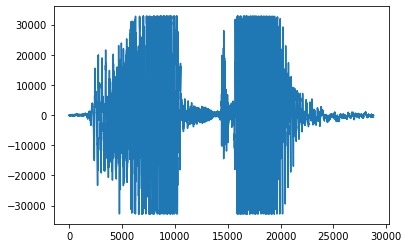

In [7]:
plt.plot(audios[0])

In [8]:
audios[0].shape[0] / sample_rate

0.6

### выравниваем длительность

In [9]:
max_duration_sec = 0.8
max_duration = round(max_duration_sec * sample_rate)
audio = audios[0]
audio = np.pad(audio, (0, max_duration - len(audio)), constant_values=0)
audio

array([-50, -64, -60, ...,   0,   0,   0], dtype=int16)

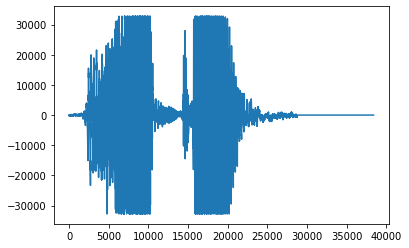

In [10]:
plt.plot(audio)

In [11]:
audio.shape[0] / sample_rate

0.8

### нормализуем аудио

$$
X := \frac{X - mean(X)}{std(X)}
$$

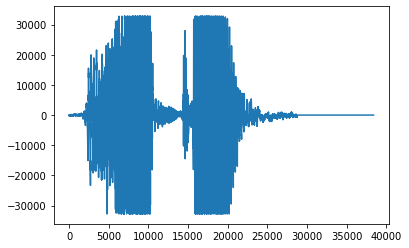

In [12]:
plt.plot(audio)

### векторизуем аудио

In [13]:
feature = librosa.feature.melspectrogram(audio.astype(float), sample_rate, n_mels=32, fmax=1000)
feature.min(), feature.max()

(0.0, 5557820787015.146)

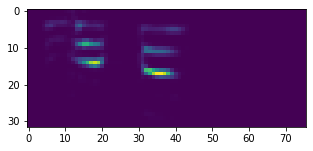

In [14]:
plt.figure(figsize=(5, 15))
plt.imshow(feature)

In [15]:
feature = librosa.amplitude_to_db(feature)
feature.min(), feature.max()

(174.8980907751846, 254.8980907751846)

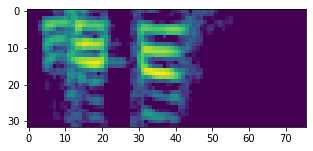

In [17]:
plt.figure(figsize=(5, 15))
plt.imshow(feature)

# Prepare features

In [18]:
max_duration_sec = 0.8
max_duration = round(max_duration_sec * sample_rate)

In [19]:
features = []
features_flatten = []
labels_flatten = []
for audio, label in zip(audios, labels):
    if len(audio) < max_duration:
        audio = np.pad(audio, (0, max_duration - len(audio)), constant_values=0)
    if len(audio) > max_duration:
        continue
    # audio := (audio - mean) / std
    feature = librosa.feature.melspectrogram(audio.astype(float), sample_rate, n_mels=16, fmax=1000)
    # feature := amplitude_to_db(feature)
    features.append(feature)
    features_flatten.append(feature.reshape(-1))
    labels_flatten.append(label)

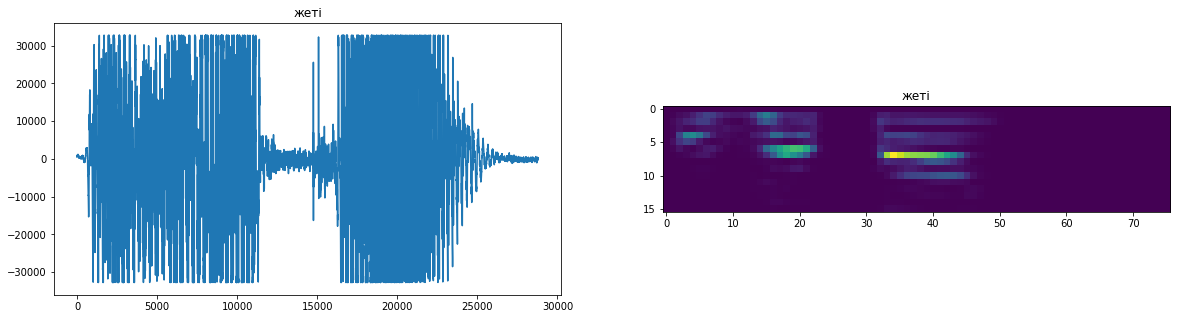

In [21]:
def plot(idx):
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.title(f"{labels[idx]}")
    plt.plot(audios[idx])

    plt.subplot(1, 2, 2)
    plt.title(f"{labels[idx]}")
    plt.imshow(features[idx])

    display(Audio(audios[idx], rate=sample_rate))
plot(4)

In [22]:
features_train, features_test, labels_train, labels_test = train_test_split(features_flatten, labels_flatten, random_state=1755)

### Обучение

In [23]:
len(features_train), features_train[1].shape

(354, (1216,))

In [24]:
len(labels_train), labels_train[1]

(354, 'үш')

### Валидация

In [25]:
len(features_test), features_test[1].shape

(118, (1216,))

In [26]:
len(labels_test), labels_test[1]

(118, 'жеті')

# Train model

https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html


In [27]:
model = RandomForestClassifier(max_depth=50, n_estimators=100, max_features=1)
#model = MLPClassifier(hidden_layer_sizes=(20,))


In [28]:
model.fit(X=features_train, y=labels_train)

RandomForestClassifier(max_depth=50, max_features=1)

# Save model

In [29]:
!mkdir models

mkdir: невозможно создать каталог «models»: Файл существует


In [30]:
import pickle

with open("models/model.pkl", "wb") as f:
    pickle.dump(model, f)

# Load model

In [31]:
import pickle

with open("models/model.pkl", "rb") as f:
    model = pickle.load(f)

# Validate model

In [32]:
labels_test_predicted = model.predict(X=features_test)

In [33]:
(labels_test_predicted == labels_test).mean()

0.8220338983050848

In [34]:
print(labels_test)
print(labels_test_predicted.tolist())

['жеті', 'жеті', 'тоғыз', 'нөл', 'тоғыз', 'бес', 'сегіз', 'нөл', 'бес', 'алты', 'үш', 'екі', 'бес', 'жеті', 'сегіз', 'алты', 'екі', 'үш', 'бір', 'тоғыз', 'бір', 'сегіз', 'бір', 'сегіз', 'төрт', 'бес', 'екі', 'алты', 'бес', 'тоғыз', 'сегіз', 'төрт', 'тоғыз', 'нөл', 'екі', 'нөл', 'төрт', 'төрт', 'жеті', 'алты', 'екі', 'тоғыз', 'бес', 'алты', 'жеті', 'төрт', 'бір', 'төрт', 'нөл', 'бес', 'екі', 'алты', 'төрт', 'сегіз', 'нөл', 'алты', 'тоғыз', 'екі', 'тоғыз', 'екі', 'бес', 'екі', 'үш', 'төрт', 'бес', 'бір', 'сегіз', 'сегіз', 'алты', 'тоғыз', 'бес', 'үш', 'екі', 'алты', 'жеті', 'төрт', 'жеті', 'нөл', 'жеті', 'жеті', 'нөл', 'сегіз', 'нөл', 'алты', 'екі', 'сегіз', 'алты', 'нөл', 'екі', 'жеті', 'тоғыз', 'алты', 'нөл', 'үш', 'нөл', 'жеті', 'сегіз', 'екі', 'үш', 'сегіз', 'тоғыз', 'тоғыз', 'жеті', 'бір', 'тоғыз', 'бес', 'бес', 'алты', 'үш', 'бес', 'нөл', 'тоғыз', 'екі', 'нөл', 'төрт', 'бір', 'алты', 'үш']
['жеті', 'жеті', 'тоғыз', 'нөл', 'тоғыз', 'бес', 'сегіз', 'нөл', 'бес', 'алты', 'үш', 'екі', 